In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from glob import glob
from RaTag.scripts.wfm2read_fast import wfm2read # type: ignore
from RaTag.scripts.wfm_sca_trigger import moving_average # type: ignore
from RaTag.scripts.analyse_field_scans import * # type: ignore
from scipy.optimize import curve_fit

# Recommended rcParams for larger font sizes
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 18


In [37]:
def save_area_array(area_array, out_path):
    np.save(out_path, area_array)

# Define Gaussian function
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-(x - mean)**2 / (2 * sigma**2))

def fit_and_plot_gaussian(hist_data, bins, label=None, color=None, mask_range=(-4, 5)):
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    mask = (bin_centers > mask_range[0]) & (bin_centers < mask_range[1])
    popt, pcov = curve_fit(gaussian, bin_centers[mask], hist_data[mask], p0=[np.max(hist_data), np.mean(bin_centers[mask]), np.std(bin_centers[mask])])
    plt.bar(bins[:-1], hist_data, width=np.diff(bins), alpha=0.5, label=label, color=color)
    plt.plot(bin_centers, gaussian(bin_centers, *popt), 'r--', label=f'Gaussian fit {label}')
    plt.legend()
    return popt, pcov


In [38]:
def load_waveform(file):
    wf = wfm2read(file)
    t, V = wf[1], -wf[0]
    return t, V
    
def subtract_baseline(t, V, t_window=(-1.5e-5, -1.0e-5), v_window=(-0.002, 0.002)):
    baseline_window = (t > t_window[0]) & (t < t_window[1])
    if v_window is not None:
        baseline_window &= (V > v_window[0]) & (V < v_window[1])
    baseline = np.min(V[baseline_window])
    V -= baseline
    return V

def integrate_s2(t, V, s2_lowcut=0.5e-5, s2_upcut=1.5e-5):
    s2_window = (t > s2_lowcut) & (t < s2_upcut)
    area_s2 = np.trapz(V[s2_window], t[s2_window]) * 1e6 / 1e-3  # mV/us

    return area_s2

def extract_s2_areas(files, threshold_bs = 0.05, integ_window=(0.5e-5, 1.5e-5), bs_t_window=(-1.5e-5, -1.0e-5), bs_v_window=None):
    areas = []
    for f in files:
        t, V = load_waveform(f)

        # 1) Reject on “too large signal in baseline window”
        baseline_mask = (t > bs_t_window[0]) & (t < bs_t_window[1])
        V_w = V[baseline_mask]
        if (V_w > threshold_bs).sum() > 5:
            continue

        # 2) Baseline‐subtract
        V_corr = subtract_baseline(t, V, bs_t_window, bs_v_window)

        # 3) Integrate S2
        area = integrate_s2(t, V_corr, integ_window[0], integ_window[1])
        areas.append(area)

    return np.array(areas)

def apply_hist_cuts(arr, lowcut, upcut):
    return arr[(arr > lowcut) & (arr < upcut)]

def analyse_field_scan(base_dir, voltage_pairs, pattern = None, s2_cuts = (1e-6, 1.5e-5),
                       hist_cuts = (-5, 20), nbins = 120):
    # Drift field scan (vary both voltages together)
    if pattern is None:
        pattern = 'FieldScan_1GSsec_EL{}_Gate{}'
    glob_pattern = pattern + '/*.wfm'
    s2_lowcut, s2_upcut = s2_cuts
    hist_lowcut, hist_upcut = hist_cuts

    s2_areas = {}
    s2_areas_cuts = {}
    for el_v, gate_v in voltage_pairs:
        path = os.path.join(base_dir, glob_pattern.format(el_v, gate_v))
        files = sorted(glob(path))
        print(f'Integrating {len(files)} files for EL {el_v} V, Gate {gate_v} V')
        arr = extract_s2_areas(files, integ_window=(s2_lowcut, s2_upcut))
        s2_areas[(el_v, gate_v)] = arr
        s2_areas_cuts[(el_v, gate_v)] = apply_hist_cuts(arr, hist_lowcut, hist_upcut)

        area_out_path = os.path.join(base_dir, pattern.format(el_v, gate_v), f'area_s2_EL{el_v}_Gate{gate_v}.npy')
        save_area_array(arr, area_out_path)

    # Plot all histograms together
    plt.figure(figsize=(8, 6))
    for (el_v, gate_v) in voltage_pairs:
        label = f"$E_{{drift}}$: {round(gate_v/1.4)} V/cm, $V_{{anode}}$: {el_v} V"
        plt.hist(s2_areas_cuts[(el_v, gate_v)], bins=nbins, alpha=0.5, label=label)
    plt.xlabel('S2 Area (mV*us)')
    plt.ylabel('Counts')
    plt.title('Drift field scan, EL field: 1.75 kV/cm')
    plt.legend(fontsize=10)
    return s2_areas_cuts, s2_areas
    # plt.savefig(os.path.join(base_dir, 'field_scan_all.png'))


# Plot waveform and windows

In [30]:
trigger_file = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL3kVcm/sca_waveform.wfm'
trig = wfm2read(trigger_file, verbose=False)
trig_x, trig_y = trig[1], trig[0]
trig_y = trig_y / (10 * np.max(trig_y))

In [31]:
path = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL1750Vcm/FieldScan_1GSsec_EL2450_Gate50'
files05 = sorted(glob(os.path.join(path, '*.wfm')))

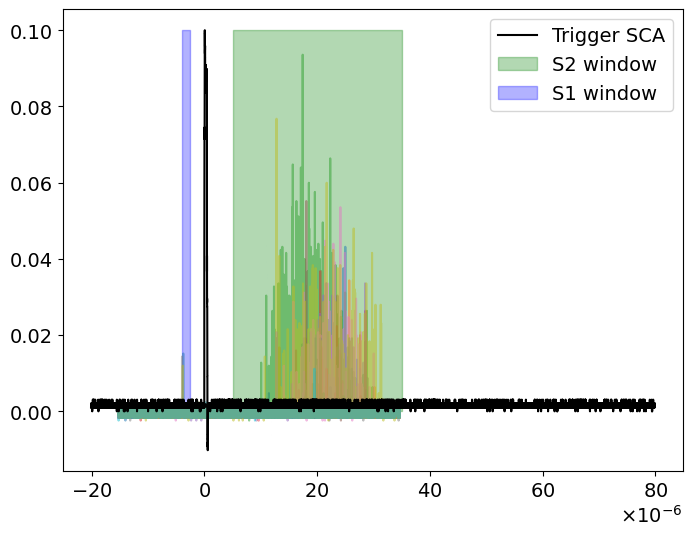

In [40]:
s2_lowcut, s2_upcut = 0.5e-5, 3.5e-5
s1_lowcut, s1_upcut = -0.4e-5, -0.25e-5
bs = -0.000772466
plt.figure(figsize=(8, 6))
for f in files05[:10]:
    wf = wfm2read(f)
    V, t = -wf[0], wf[1]
    V -= bs
    plt.plot(t, V, alpha=0.5)

plt.plot(trig_x, trig_y, label='Trigger SCA', color='black')
plt.fill_betweenx([0, 0.1], x1=s2_lowcut, x2=s2_upcut,
        color='green', alpha=0.3, label='S2 window')

plt.fill_betweenx([0, 0.1], x1=s1_lowcut, x2=s1_upcut,
        color='blue', alpha=0.3, label='S1 window')

# plt.gca().set(xlim=(-1e-5, 3.5e-5), ylim=(-0.005, 0.05), xlabel='t (s)', ylabel='Amplitude (V)')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-6, -6))

# Field scan, low range

In [32]:
path05 = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL3kVcm/FieldScan_1GSsec_EL2450_Gate50'
files05 = sorted(glob(os.path.join(path05, '*.wfm')))

In [ ]:
as2 = extract_s2_areas(files05, threshold_bs=0.05, integ_window=(1e-6 ,1.5e-5), bs_t_window=(-1.5e-5, -1.0e-5), bs_v_window=None)
len(as2)

2974

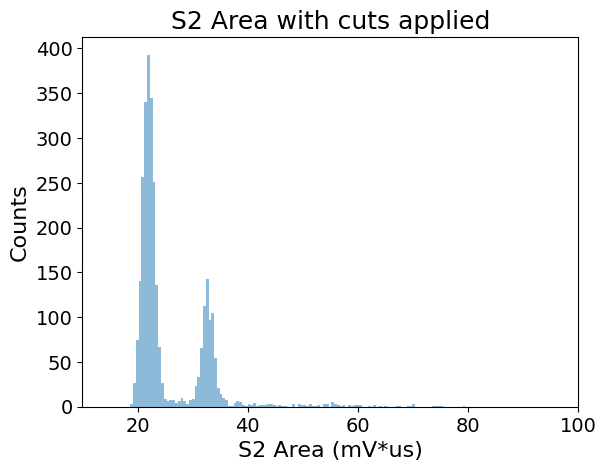

In [ ]:
as2_cuts = apply_hist_cuts(as2, -8, 80)
plt.hist(as2_cuts, bins=120, alpha=0.5);
plt.gca().set(xlabel='S2 Area (mV*us)', ylabel='Counts', xlim=(10, 100), title='S2 Area with cuts applied');

In [39]:
import re
voltage_pairs = []
subdirs = sorted(os.listdir('/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL3kVcm/'))
for subdir in subdirs:
    try:
        gate_voltage = int(re.search(r'Gate(\d+)', subdir).group(1))
        anode_voltage = int(re.search(r'EL(\d+)', subdir).group(1))
        print(f"Anode voltage : {anode_voltage}, Gate voltage : {gate_voltage}")
        voltage_pairs.append((anode_voltage, gate_voltage))
    except AttributeError:
        continue

Anode voltage : 2450, Gate voltage : 50
Anode voltage : 2460, Gate voltage : 60
Anode voltage : 2470, Gate voltage : 70
Anode voltage : 2480, Gate voltage : 80
Anode voltage : 2490, Gate voltage : 90
Anode voltage : 2500, Gate voltage : 100
Anode voltage : 2550, Gate voltage : 150
Anode voltage : 2600, Gate voltage : 200
Anode voltage : 2650, Gate voltage : 250
Anode voltage : 2700, Gate voltage : 300
Anode voltage : 2750, Gate voltage : 350
Anode voltage : 2800, Gate voltage : 400
Anode voltage : 2850, Gate voltage : 450
Anode voltage : 2900, Gate voltage : 500
Anode voltage : 3000, Gate voltage : 600


In [43]:
E_drift = [v[1]/0.8 for v in voltage_pairs]
np.array(E_drift)

array([ 62.5,  75. ,  87.5, 100. , 112.5, 125. , 187.5, 250. , 312.5,
       375. , 437.5, 500. , 562.5, 625. , 750. ])

Integrating 3000 files for EL 2450 V, Gate 50 V
Integrating 3000 files for EL 2460 V, Gate 60 V
Integrating 3000 files for EL 2470 V, Gate 70 V
Integrating 3000 files for EL 2480 V, Gate 80 V
Integrating 3000 files for EL 2490 V, Gate 90 V
Integrating 3000 files for EL 2500 V, Gate 100 V
Integrating 3000 files for EL 2550 V, Gate 150 V
Integrating 3000 files for EL 2600 V, Gate 200 V
Integrating 3000 files for EL 2650 V, Gate 250 V
Integrating 3000 files for EL 2700 V, Gate 300 V
Integrating 3000 files for EL 2750 V, Gate 350 V
Integrating 3000 files for EL 2800 V, Gate 400 V
Integrating 3000 files for EL 2850 V, Gate 450 V
Integrating 3000 files for EL 2900 V, Gate 500 V
Integrating 3000 files for EL 3000 V, Gate 600 V


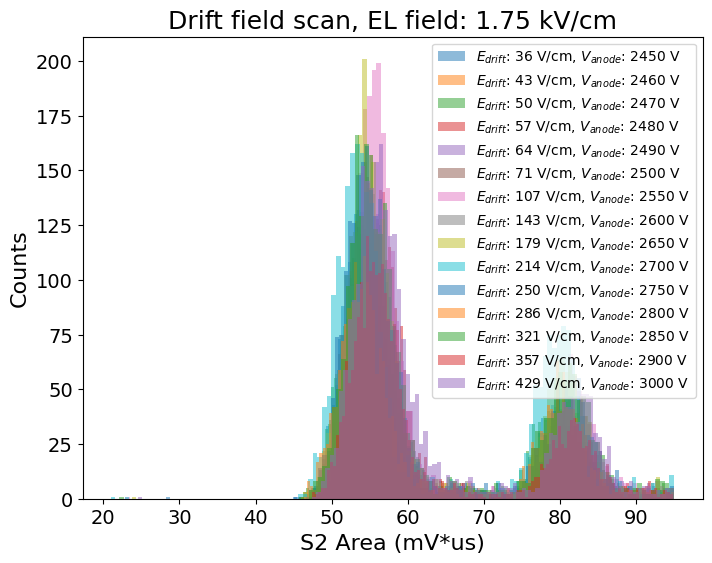

In [35]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL3kVcm/'
pattern = 'FieldScan_1GSsec_EL{}_Gate{}'
s2_lowcut, s2_upcut = 1e-6, 3.5e-5
hist_lowcut, hist_upcut = -8, 95

as2_cuts, as2 = analyse_field_scan(base_dir, voltage_pairs, pattern,
                                  s2_cuts=(s2_lowcut, s2_upcut), hist_cuts=(hist_lowcut, hist_upcut))

In [238]:
as2_cuts

{(2450,
  50): array([81.54080577, 53.93800382, 89.21000631, ..., 54.37720385,
        56.516004  , 84.11520595]),
 (2460,
  60): array([51.13840362, 50.65480359, 89.99640637, ..., 55.26840391,
        80.96720573, 57.39320406]),
 (2470,
  70): array([52.60400372, 76.68000543, 55.1264039 , ..., 51.78880367,
        54.43360385, 51.17240362]),
 (2480,
  80): array([58.90560417, 58.01320411, 60.29080427, ..., 60.17200426,
        78.69480557, 57.8608041 ]),
 (2490,
  90): array([52.65640373, 79.20680561, 79.19720561, ..., 53.96560382,
        80.34600569, 54.36680385]),
 (2500,
  100): array([81.69920578, 69.31680491, 56.34920399, ..., 56.64160401,
        55.25680391, 53.31200377]),
 (2550,
  150): array([58.71000416, 56.28200398, 53.82240381, ..., 56.464404  ,
        56.43280399, 53.05440376]),
 (2600,
  200): array([80.38880569, 54.28240384, 56.01040396, ..., 58.15520412,
        58.85240417, 55.75520395]),
 (2650,
  250): array([54.09880383, 92.55560655, 54.71400387, ..., 52.2628037

In [25]:
# as2_cuts = {**as2_cuts_hi, **as2_cuts_mid, **as2_cuts_lo}
# as2_cuts = {**as2_cuts_mid, **as2_cuts_lo}

# Loop over all histograms in as2_cuts and fit/plot
fit_results_rap = {}
fit_results_rapp = {}
for key, a1 in as2_cuts.items():
    n, bins = np.histogram(a1, bins=100)
    
    popt_rap, pcov_rap = fit_and_plot_gaussian(n, bins, label=str(key), mask_range=(0, 70), color='blue')

    popt_rapp, pcov_rapp = fit_and_plot_gaussian(n, bins, label=str(key), mask_range=(70, 100), color='blue')

    # plt.clf()
    plt.show()

    fit_results_rap[key] = (popt_rap, pcov_rap)
    fit_results_rapp[key] = (popt_rapp, pcov_rapp)
    print(f'{key}: amplitude={popt_rap[0]:.2f}, mean={popt_rap[1]:.2f}, sigma={popt_rap[2]:.2f})')
    print(f'{key}: amplitude={popt_rapp[0]:.2f}, mean={popt_rapp[1]:.2f}, sigma={popt_rapp[2]:.2f})')

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [24]:
mean_gaussian_rap = []
ci95_gaussian_rap = []


for popt, pcov in fit_results_rap.values():
    mean = popt[1]
    rms = popt[2]
    std_error = np.sqrt(pcov[1, 1])
    ci95 = 1.96 * std_error
    mean_gaussian_rap.append(mean)
    ci95_gaussian_rap.append(ci95)
    # rms_gaussian_rap.append(rms)

mean_gaussian_rapp = []
ci95_gaussian_rapp = []
for popt, pcov in fit_results_rapp.values():
    mean = popt[1]
    rms = popt[2]
    std_error = np.sqrt(pcov[1, 1])
    ci95 = 1.96 * std_error
    mean_gaussian_rapp.append(mean)
    ci95_gaussian_rapp.append(ci95)

E_gate = [f[1]/1.4 for f in fit_results_rap.keys()]
V_gate = [f[1] for f in fit_results_rap.keys()]
plt.errorbar(E_gate, mean_gaussian_rapp, yerr=ci95_gaussian_rapp, fmt='o', color='red', capsize=10, capthick=2, label='High S2 area peak')
# plt.errorbar(E_gate, mean_gaussian_rap, yerr=ci95_gaussian_rap, fmt='o', color='orange', capsize=10, capthick=2, label='Low S2 area peak')
# plt.errorbar(V_gate, mean_gaussian_rap, yerr=ci95_gaussian_rap, fmt='o', color='orange', capsize=10, capthick=2)
# plt.errorbar(V_gate, mean_gaussian_rapp, yerr=ci95_gaussian_rapp, fmt='o', color='red', capsize=10, capthick=2)

plt.legend()
plt.gca().set(xlabel='$E_{drift}$ (V/cm)', ylabel='Mean S2 Area (mV$\cdot$us)', 
              title='Mean S2 Area vs $E_{drift}$ (95% CI)', )
            #   xlim=(0, 550), ylim=(-0.7, 0.7))

NameError: name 'fit_results_rap' is not defined

[Text(0.5, 0, '$E_{drift}$ (V/cm)'),
 Text(0, 0.5, 'Mean S2 Area (mV$\\cdot$us)'),
 Text(0.5, 1.0, 'Mean S2 Area vs $E_{drift}$ (95% CI)')]

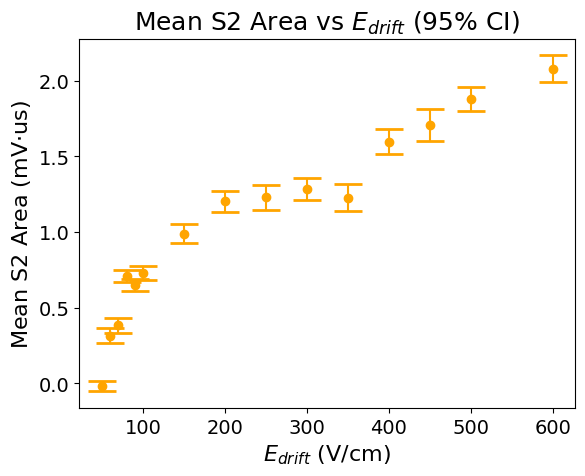

In [ ]:
mean_gaussian = []
ci95_gaussian = []
rms_gaussian = []
for popt, pcov in fit_results.values():
    mean = popt[1]
    rms = popt[2]
    std_error = np.sqrt(pcov[1, 1])
    ci95 = 1.96 * std_error
    mean_gaussian.append(mean)
    ci95_gaussian.append(ci95)
    rms_gaussian.append(rms)

E_gate = [f[1]/1.4 for f in fit_results.keys()]
V_gate = [f[1] for f in fit_results.keys()]
# plt.errorbar(E_gate, mean_gaussian, yerr=ci95_gaussian, fmt='o', color='orange', capsize=10, capthick=2)
plt.errorbar(V_gate, mean_gaussian, yerr=ci95_gaussian, fmt='o', color='orange', capsize=10, capthick=2)

plt.gca().set(xlabel='$E_{drift}$ (V/cm)', ylabel='Mean S2 Area (mV$\cdot$us)', 
              title='Mean S2 Area vs $E_{drift}$ (95% CI)', )
            #   xlim=(0, 550), ylim=(-0.7, 0.7))

In [32]:
path_result = r'E:\Pablos_Mighty_measurements\RUN1\FieldScans\s2_area_ci95.csv'
df = pd.DataFrame({'E_gate': E_gate, 'mean_gaussian': mean_gaussian, 'ci95_gaussian': ci95_gaussian})
df.to_csv(path_result, index=False)

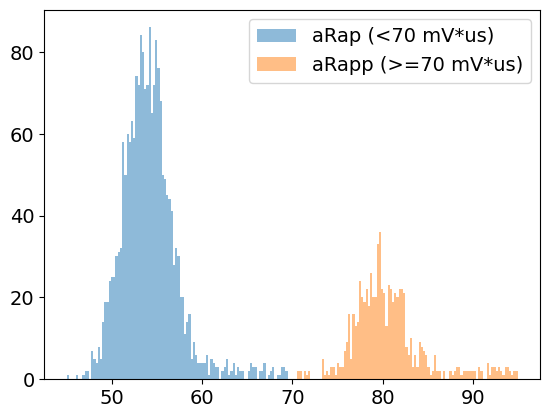

In [251]:
as2_cuts[(2450, 50)]
aRap = as2_cuts[(2450, 50)][as2_cuts[(2450, 50)] < 70]
aRapp = as2_cuts[(2450, 50)][as2_cuts[(2450, 50)] >= 70]
nRap,binsp, _ = plt.hist(aRap, bins=100, alpha=0.5, label='aRap (<70 mV*us)')
nRapp, binspp, _ = plt.hist(aRapp, bins=100, alpha=0.5, label='aRapp (>=70 mV*us)')
plt.legend()

In [253]:
nRapp.sum(), nRap.sum()

(724.0, 2025.0)

# Debug function

In [10]:
voltage_pairs[:3]

[(2450, 50), (2460, 60), (2470, 70)]

Integrating 3000 files for EL 2450 V, Gate 50 V
Integrating 3000 files for EL 2460 V, Gate 60 V
Integrating 3000 files for EL 2470 V, Gate 70 V
Integrating 3000 files for EL 2480 V, Gate 80 V
Integrating 3000 files for EL 2490 V, Gate 90 V
Integrating 3000 files for EL 2500 V, Gate 100 V
Integrating 3000 files for EL 2550 V, Gate 150 V
Integrating 3000 files for EL 2600 V, Gate 200 V
Integrating 3000 files for EL 2650 V, Gate 250 V
Integrating 3000 files for EL 2700 V, Gate 300 V
Integrating 3000 files for EL 2750 V, Gate 350 V
Integrating 3000 files for EL 2800 V, Gate 400 V
Integrating 3000 files for EL 2850 V, Gate 450 V
Integrating 3000 files for EL 2900 V, Gate 500 V
Integrating 3000 files for EL 3000 V, Gate 600 V


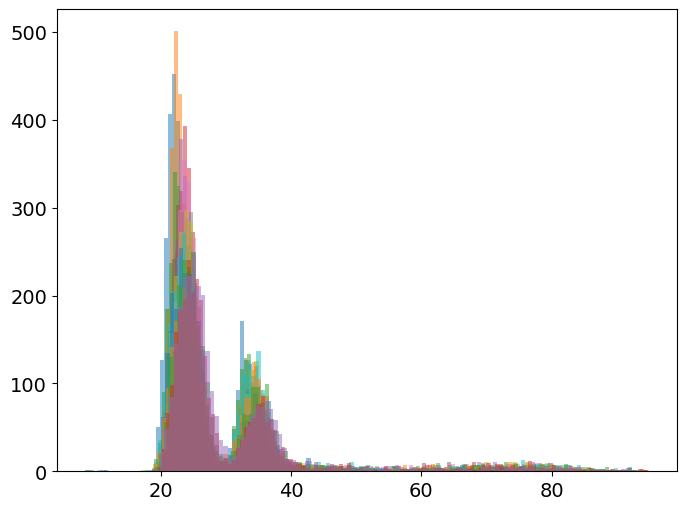

In [16]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/FieldScans_EL3kVcm/'
pattern = 'FieldScan_1GSsec_EL{}_Gate{}'
s2_lowcut, s2_upcut = 1e-6, 3.5e-5
hist_lowcut, hist_upcut = -8, 95
nbins = 120

# as2_cuts, as2 = analyse_field_scan(base_dir, voltage_pairs, pattern,
                                #   s2_cuts=(s2_lowcut, s2_upcut), hist_cuts=(hist_lowcut, hist_upcut))
s2_areas = {}
s2_areas_cuts = {}
for el_v, gate_v in voltage_pairs:
    path = os.path.join(base_dir, pattern.format(el_v, gate_v), '*.wfm')
    files = sorted(glob(path))
    print(f'Integrating {len(files)} files for EL {el_v} V, Gate {gate_v} V')
    arr = extract_s2_areas(files, threshold_bs=0.05, integ_window=(1e-6 ,3.5e-5), bs_t_window=(-1.5e-5, -1.0e-5), bs_v_window=None)
    s2_areas[(el_v, gate_v)] = arr
    s2_areas_cuts[(el_v, gate_v)] = apply_hist_cuts(arr, hist_lowcut, hist_upcut)

# Plot all histograms together
plt.figure(figsize=(8, 6))
for (el_v, gate_v) in voltage_pairs:
    label = f"$E_{{drift}}$: {round(gate_v/1.4)} V/cm, $V_{{anode}}$: {el_v} V"
    plt.hist(s2_areas_cuts[(el_v, gate_v)], bins=nbins, alpha=0.5, label=label)